In [3]:
os.chdir()"~/qnm-fitting"
os.system("LoadPython.sh")

SyntaxError: invalid syntax (<ipython-input-3-b14baa569b0a>, line 1)

In [1]:
import os
import SetupData
import qnm
from scipy.optimize import least_squares
import numpy as np
from matplotlib import pyplot as plt


In [2]:
ksc = qnm.cached.KerrSeqCache(init_schw=False)
Yl2m2 = SetupData.get_Yl2m2("/Users/isaaclegred/qnm-fitting/SXSDATA0305/Lev2/rhOverM_Asymptotic_GeometricUnits_CoM.h5")

In [3]:
Yl2m2[:,0]

array([-107.86222981, -106.96915089, -106.0847403 , ..., 3843.358489  ,
       3843.45848512, 3843.55848125])

In [4]:
a_strain = np.sqrt(Yl2m2[:,1]**2 + Yl2m2[:,2]**2)

In [5]:
np.where((a_strain == max(a_strain)))

(array([12280]),)

In [ ]:
max_frame = 12280

In [ ]:
Omegas = [ksc(s = -2, l = 2, m = 2, n = i)(a=.68) for i in range(0,7)]

In [ ]:
Ringdown = Yl2m2[12280:,:]

In [ ]:
CompRingdown = Ringdown[:,1] - 1j * Ringdown[:,2]

In [ ]:
CompStrain = Yl2m2[:,1] - 1j*Yl2m2[:,2]

In [ ]:
DeltaT = (Yl2m2[-1, 0]- Yl2m2[0, 0])/len(Yl2m2)
freqs = np.fft.fftfreq(len(CompStrain))/DeltaT*2*np.pi

In [ ]:
plt.plot(freqs, np.real(np.fft.fft(CompStrain)), "-r")
plt.plot(freqs, np.imag(np.fft.fft(CompStrain)), "-b")
plt.xlim(-.1,.3)
plt.plot(construct_fourier_trial(x0,start_grid),  "-og")

In [ ]:
plt.plot(CompStrain.real)

In [ ]:
CompPreRing = CompStrain[0:-len(CompRingdown)]
plt.plot(CompPreRing.real)
plt.figure()
plt.plot(CompRingdown.real)
plt.plot(CompRingdown.imag)


In [ ]:
dt = (Ringdown[-1,0] - Ringdown[0,0])/len(Ringdown)
RDfreqs = np.fft.fftfreq(len(CompRingdown))
plt.plot(RDfreqs/dt*2*np.pi, np.real(np.fft.fft(CompRingdown*dt)), "-r", label = "real")
plt.plot(RDfreqs/dt*2*np.pi, np.imag(np.fft.fft(CompRingdown*dt)), "-b", label = "imaginary")
plt.xlim(-2,2)
plt.xlabel("$\omega(1/M)$")
plt.ylabel("$C(\omega)$")
plt.title("Fourier Transform of the ringdown signal")
plt.legend()

The frequencies that are recovered by the `np.fft.fftfreq` method are equally spaced values of $k=\Delta T \omega$, so in order to recover true frequencies we have to take $k/ \Delta T = \omega$, where $\Delta T$ is the actual time separation between data points

In [ ]:
np.fft.fftfreq(len(CompRingdown))

In [ ]:
Ringdowntime*.005

In [ ]:
# The fundamental mode converted into 1/seconds
Omegas[1][0]*305.476359 


In [27]:
# This is most likely the correct way to recover physical 
# frequencies from the fft
.008/dt*2*np.pi

0.503061282962366

In [20]:
def get_complex_test_funcs(A, grid):
    grid/x[15]
    ksc = qnm.cached.KerrSeqCache(init_schw=False)
    test_funcs = []
    for i in range(7):
        mode_seq = ksc(s = -2, l = 2, m = 2, n = i)
        freq = mode_seq(a = A)[0]
        test_funcs.append(np.exp(-1j*freq*grid))
    return test_funcs
def construct_complex_trial_from_grid(x, grid):

    a = x[14]
    M = x[15]
    dt = (grid[-1] - grid[0])/M*len(grid)
    test_funcs = get_complex_test_funcs(a, grid)
    trial = np.zeros((len(test_funcs[0])), dtype = np.complex128)
    for i in range(7):
        phi = np.arctan2(x[2*i], x[2*i+1])
        r = abs(x[2*i+1]+1j*x[2*i])
        print(r, phi)
        trial += r*np.exp(-1j*phi)*test_funcs[i]
    return trial
def construct_fourier_trial(x, grid):
    grid = grid/x[15]
    dt = (grid[-1] - grid[0])/len(grid)
    freq_grid = np.fft.fftfreq(len(grid))/dt*2*np.pi
    trial = np.zeros(len(freq_grid), dtype=np.complex128)
    for i in range(7):
        mode_seq = ksc(s = -2, l = 2, m = 2, n = i)
        freq = mode_seq(a = x[14])[0]
        trial += (x[2*i]- 1j*x[2*i+1])/(freq - freq_grid)
    return trial
def Residuals(x, params0, params2):
    target = params0
    grid = params2/x[15]        
    trial = construct_fourier_trial(x, grid)
    residuals = np.abs(target - trial)[0]
    return residuals

In [22]:
signal = np.fft.fft(CompRingdown*dt)
x0 = np.ones(16)
x0[14] = .68
x0[15] = .9
start_grid = Ringdown[:,0] - Ringdown[0,0]
lower_bounds = [-np.inf]*14
upper_bounds = [np.inf]*14
lower_bounds += [0,0]
upper_bounds += [1, 1.2]
Bounds =(lower_bounds, upper_bounds)
X = least_squares(Residuals, x0 , args=(signal, start_grid),bounds=Bounds , ftol=20**-15, gtol = 10**-15)

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/optimize/_lsq/least_squares.py:111: UserWarning: `ftol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`ftol`", EPS))


In [76]:
X

 active_mask: array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
        cost: 1.7004721409394907e-15
         fun: array([5.83176155e-08])
        grad: array([5.13814852e-08, 5.13814852e-08, 3.38794890e-08, 3.38794890e-08,
       5.68164813e-08, 5.68164813e-08, 6.27029711e-08, 6.27029711e-08,
       6.18522270e-08, 6.18522270e-08, 5.36031977e-08, 5.36031977e-08,
       4.62779946e-08, 4.62779946e-08, 7.10993588e-08, 0.00000000e+00])
         jac: array([[0.88106286, 0.88106286, 0.58094778, 0.58094778, 0.97425934,
        0.97425934, 1.07519779, 1.07519779, 1.06060967, 1.06060967,
        0.91915963, 0.91915963, 0.79355087, 0.79355087, 1.21917466,
        0.        ]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 78
        njev: 64
  optimality: 6.270297106802007e-08
      status: 3
     success: True
           x: array([ 0.03222029,  0.03222029, -0.2128222 , -0.2128222 , -0.23714227,
       -0.23714227, -0.12480103, -0.12480103,  0.02499933,  0.0249

In [57]:
np.abs(CompRingdown-trial)[0]

array([nan, nan, nan, ..., nan, nan, nan])

In [178]:
trial= construct_complex_trial_from_grid(x, start_grid)

0.5154279060607523 -1.8379386642714999
0.6075121571771716 0.33435370475392345
0.28738238531509097 -2.240595752763223
1.135022624444276 2.3432408378249567
2.0874680581609555 -0.5104684762077683
1.6513476802998321 2.851041812149421
0.47921001401550084 -0.08647190393639384


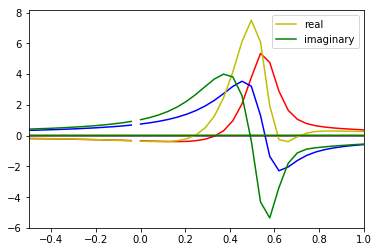

In [191]:
freq_grid = np.fft.fftfreq(len(start_grid))/dt*2*np.pi
freq_grid ,
plt.plot(freq_grid,-construct_fourier_trial(x,start_grid).real, "-r")
plt.plot(freq_grid,construct_fourier_trial(x,start_grid).imag, "-b")
plt.plot(RDfreqs/dt*2*np.pi, np.real(np.fft.fft(CompRingdown*dt)), "-y", label = "real")
plt.plot(RDfreqs/dt*2*np.pi, np.imag(np.fft.fft(CompRingdown*dt)), "-g", label = "imaginary")
plt.xlim(-.5,1)
plt.legend()

In [31]:
x=  [-0.13606071, -0.49714526,  0.57386971,  0.19936042, -0.17841525, -0.22529233,
 -0.79211878,  0.81291094,  1.82134868, -1.01990778, -1.58213345,  0.47307812,
  0.47741951, -0.04138658,  0.68810123,  0.94885669]

(-0.5, 1)

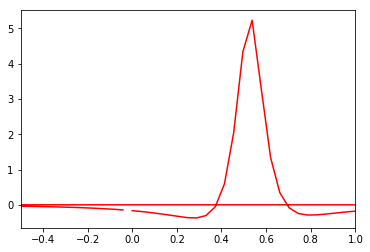

In [104]:
plt.plot(freq_grid,-construct_fourier_trial(x,start_grid).real, "-r")
plt.xlim(-.5,1)

In [218]:
time_space_trial = construct_complex_trial_from_grid(x, start_grid)

0.5154279060607523 -2.87445031611319
0.6075121571771716 1.2364426220409732
0.28738238531509097 -2.471793227621467
1.135022624444276 -0.77244451103006
2.0874680581609555 2.081264803002665
1.6513476802998321 -1.2802454853545244
0.47921001401550084 1.6572682307312905


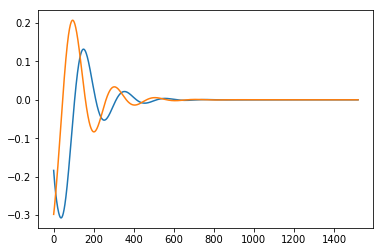

In [159]:
plt.plot(time_space_trial.real)
plt.plot(time_space_trial.imag)
plt.show()

In [89]:
start_grid

array([0.00000000e+00, 9.99880441e-02, 1.99975969e-01, ...,
       1.51777116e+02, 1.51877112e+02, 1.51977108e+02])

In [90]:
get_complex_test_funcs(.7, start_grid)

[array([1.00000000e+00+0.00000000e+00j, 9.90547986e-01-5.28002247e-02j,
        9.78397464e-01-1.04602251e-01j, ...,
        3.13697287e-06+3.53426079e-06j, 3.29394413e-06+3.33520568e-06j,
        3.43892057e-06+3.12974342e-06j]),
 array([ 1.00000000e+00+0.00000000e+00j,  9.74550203e-01-5.08296772e-02j,
         9.47164476e-01-9.90720884e-02j, ...,
        -6.74038262e-17+4.23021282e-17j, -6.35378954e-17+4.46518419e-17j,
        -5.96509154e-17+4.67452314e-17j]),
 array([1.00000000e+00+0.00000000e+00j, 9.58418281e-01-4.79461385e-02j,
        9.16266819e-01-9.19048611e-02j, ...,
        5.94539722e-28-3.06587259e-28j, 5.55114910e-28-3.22345887e-28j,
        5.16573958e-28-3.35558776e-28j]),
 array([ 1.00000000e+00+0.00000000e+00j,  9.42203478e-01-4.44370643e-02j,
         8.85772808e-01-8.37374690e-02j, ...,
        -2.30094273e-39-2.01225731e-39j, -2.25737122e-39-1.79369162e-39j,
        -2.20660504e-39-1.58969561e-39j]),
 array([ 1.00000000e+00+0.00000000e+00j,  9.26500467e-01-4.08231

In [82]:
start_grid - start_grid[0]

array([0.00000000e+00, 9.99880441e-02, 1.99975969e-01, ...,
       1.51777116e+02, 1.51877112e+02, 1.51977108e+02])

(-0.5, 1)

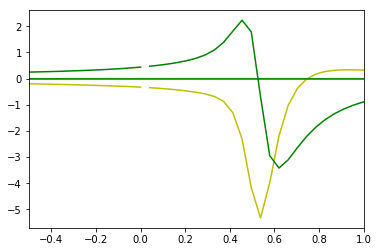

In [219]:
plt.plot(-freq_grid, np.real(np.fft.fft(time_space_trial*dt)), "-y", label = "real")
plt.plot(-freq_grid, np.imag(np.fft.fft(time_space_trial*dt)), "-g", label = "imaginary")
plt.xlim(-.5,1)

In [194]:
np.arctan2(2,1)

1.1071487177940904